# Clasificación de imagenes deportivas

## Importar librerias

In [1]:
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

## Cargar dataset

### Carga de archivo `.csv` con la información de las imagenes del dataset

Se cargan los ids, ubicación, labels y dataset (train, test, validation) al que pertenecen las imagenes.

In [2]:
data_info = pd.read_csv("sports.csv")
data_info.head()

,class_id,filepaths,labels,dataset
0,0,train/air hockey/001.jpg,air hockey,train
1,0,train/air hockey/002.jpg,air hockey,train
2,0,train/air hockey/003.jpg,air hockey,train
3,0,train/air hockey/004.jpg,air hockey,train
4,0,train/air hockey/005.jpg,air hockey,train


### Analisis exploratorio

#### Conteo de instancias de cada categoria

Se evalúa si el dataset está balanceado

In [3]:
data_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14492 entries, 0 to 14491
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class_id   14492 non-null  int64 
 1   filepaths  14492 non-null  object
 2   labels     14492 non-null  object
 3   dataset    14492 non-null  object
dtypes: int64(1), object(3)
memory usage: 453.0+ KB


In [4]:
label_counts = data_info["labels"].value_counts()
label_counts.head()

labels
football            201
formula 1 racing    200
nascar racing       199
baseball            184
hockey              182
Name: count, dtype: int64

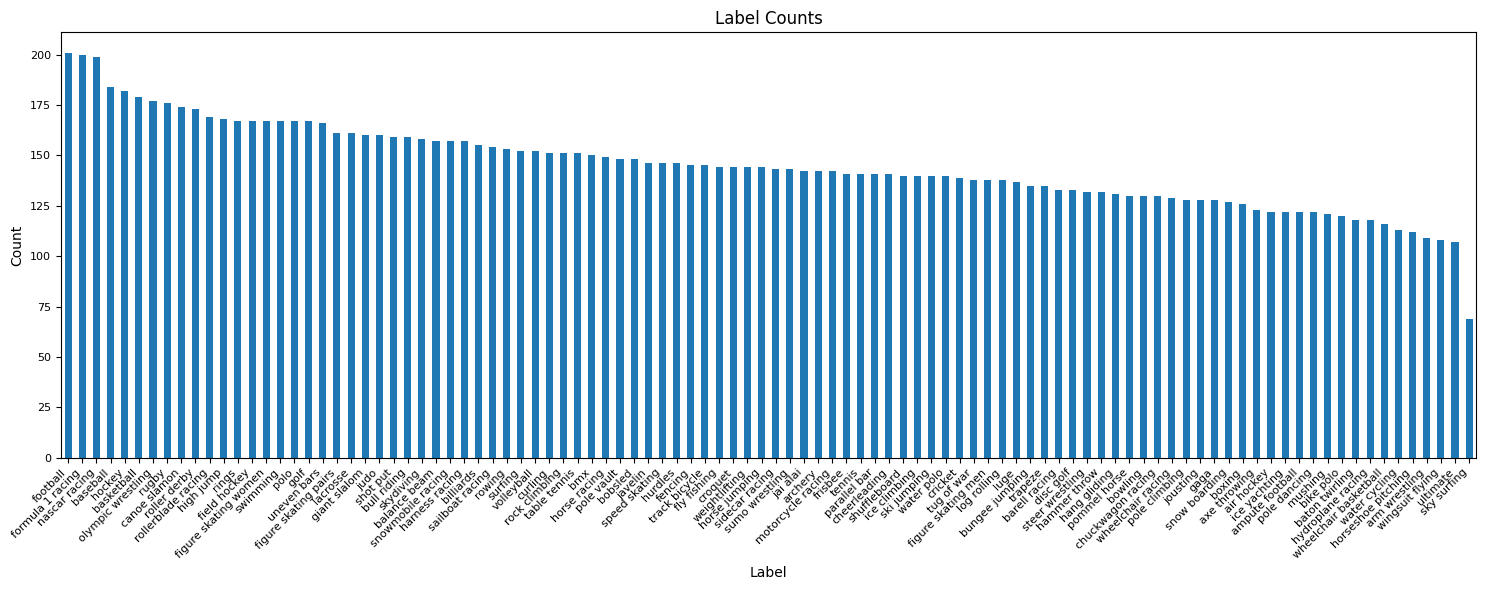

In [5]:
# Create plot
plt.figure(figsize=(15, 6))

# Histogram
ax = label_counts.plot(kind="bar", legend=False)

# Customization
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.set_title("Label Counts")

# Rotate and align x-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
    tick.set_horizontalalignment("right")
    tick.set_x(tick.get_position()[0]- 0.05)

# Adjust tick font size
ax.tick_params(axis="x", labelsize=8)
ax.tick_params(axis="y", labelsize=8)

plt.tight_layout()
plt.show()

#### Evaluar outliers para la cantidad de instancias

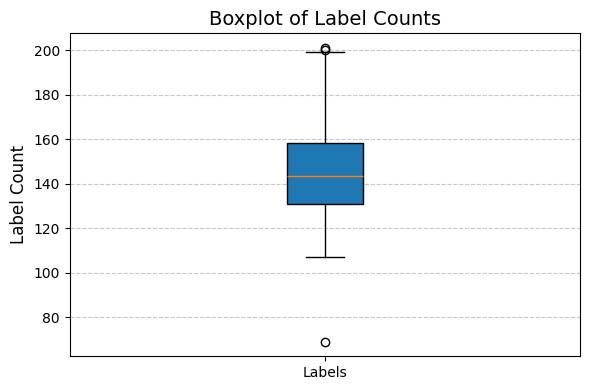

In [6]:
# Create boxplot
plt.figure(figsize=(6, 4))
plt.boxplot(label_counts, vert=True, patch_artist=True)

# Customize
plt.ylabel("Label Count", fontsize=12)
plt.title("Boxplot of Label Counts", fontsize=14)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks([1], ["Labels"])

plt.tight_layout()
plt.show()

#### Eliminación de outliers mediante el método IQR

In [7]:
def detect_outliers_IQR(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Returns a filtered series per IQR method (interquartile range)
    Parameters:
    - series: pd.Series -> Input DataFrame
    - k: float (Optional) -> Multiplier for IQR threshold (default = 1.5)

    Returns:
    - pd.Series -> series after the filter is applied.
    """
    # IQR method
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR

    return series[(series >= lower_bound) & (series <= upper_bound)]

In [8]:
label_counts = detect_outliers_IQR(label_counts, k=1.0)

In [9]:
# Filter the original DataFrame
data_info = data_info[data_info["labels"].isin(label_counts.index)]
data_info.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13823 entries, 0 to 14491
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   class_id   13823 non-null  int64 
 1   filepaths  13823 non-null  object
 2   labels     13823 non-null  object
 3   dataset    13823 non-null  object
dtypes: int64(1), object(3)
memory usage: 540.0+ KB


### Aplicar LabelEncoder a los labels

In [10]:
encoder = LabelEncoder()
encoder.fit(data_info["labels"])

LabelEncoder()

In [11]:
data_info["encoded_labels"] = encoder.transform(data_info["labels"])
data_info.sample(5)

,class_id,filepaths,labels,dataset,encoded_labels
11826,86,train/table tennis/080.jpg,table tennis,train,82
8041,59,train/olympic wrestling/014.jpg,olympic wrestling,train,56
11742,85,train/swimming/153.jpg,swimming,train,81
13185,97,train/wheelchair basketball/017.jpg,wheelchair basketball,train,93
11464,84,train/surfing/017.jpg,surfing,train,80


In [12]:
data_info.to_csv("sports_updated.csv", index=False)

### Crear Custom Class para cargar imagen desde `filepath`

In [13]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from typing import Callable, Optional

# Create a custom type for transform
# which is a function that takes and `Image`
# and returns a torch.tensor
transform_type = Callable[[Image.Image], torch.Tensor]


class ImageDatasetLoader(Dataset):
    def __init__(self, data: pd.DataFrame, root_dir: str, transform: transform_type, split: str = "train") -> None:
        self.data = data
        self.data = self.data[self.data["filepaths"].str.startswith(split)] # take only the data according to `split`
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> tuple[torch.Tensor, int]:
        img_path = f"{self.root_dir}/{self.data["filepaths"].iloc[idx]}" # get the path of the image at index idx
        image = Image.open(img_path).convert("RGB")
        label = int(self.data["encoded_labels"].iloc[idx])
        
        if self.transform:
            image = self.transform(image)
        
        # Enforce torch.Tensor type
        if not isinstance(image, torch.Tensor):
            raise TypeError(f"Expected image to be transformed to torch.Tensor, got {type(image)}")

        return image, label


### Crear Transforms

Se crean transforms para llevar todas las imagenes al mismo tamaño y transformar a Tensor. Luego, se normalizan las imagenes.

In [14]:
IMAGE_SIZE = 128

transform = transforms.Compose([
                                transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # ensure size 224x224 pixels
                                transforms.ToTensor(), # transform image to torch.Tensor
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], # apply normalization
                                                     std=[0.229, 0.224, 0.225])  # values recommended by ImageNet
                                ])

### Crear Datasets & DataLoaders

In [15]:
BATCH_SIZE = 32

train_dataset = ImageDatasetLoader(data=data_info, root_dir="dataset", transform=transform, split="train")
test_dataset = ImageDatasetLoader(data=data_info, root_dir="dataset", transform=transform, split="test")
valid_dataset = ImageDatasetLoader(data=data_info, root_dir="dataset", transform=transform, split="valid")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Visualizar datos

IMPORTANTE: Los colores se verán extraños porque durante la carga de datos las imagenes fueron normalizadas.

In [16]:
image, label = train_dataset[0]

In [17]:
print(f"{image.shape=}")

image.shape=torch.Size([3, 128, 128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


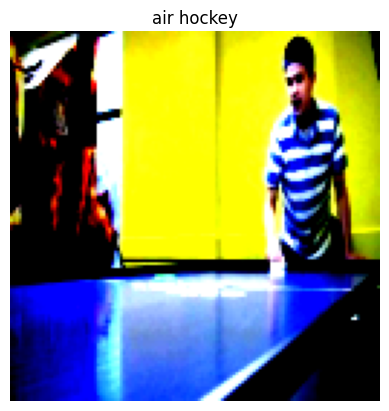

In [18]:
# Change image to hwc format
image_np_hwc = image.numpy().transpose(1, 2, 0)
plt.imshow(image_np_hwc)
plt.title(str(encoder.inverse_transform([label])[0]))
plt.axis("off")
plt.show()

## Entrenamiento de modelo

In [19]:
print(f"DataLoader de Entrenamiento: {len(train_loader)} BATCHES con {BATCH_SIZE} ELEMENTOS")

DataLoader de Entrenamiento: 402 BATCHES con 32 ELEMENTOS


### Hiperparámetros del modelo

In [20]:
# Number of input channels
INPUT_CHANNELS = 3

# Calculate the total number of labels
NUM_LABELS = data_info["labels"].nunique()

# Number of hidden units
HIDDEN_UNITS = 16

print(f"{INPUT_CHANNELS=}")
print(f"{NUM_LABELS=}")
print(f"{HIDDEN_UNITS=}")

INPUT_CHANNELS=3
NUM_LABELS=96
HIDDEN_UNITS=16


### Modelo base

In [21]:
# device = torch.device("cpu")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [22]:
from torch import nn

class SportsImageModelV0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int) -> None:
        super().__init__()
        
        # Convolutional block
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
            )
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.25)
        
        # Find the right shape for the classifier layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, INPUT_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
            dummy_output = self.conv_block_1(dummy_input)
            self.flattened_size = dummy_output.view(1, -1).size(1)
            print(f"Flattened Size: {self.flattened_size}")
            
        # Fully connected layers
        self.classifier_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=self.flattened_size,
                      out_features=128),
            nn.BatchNorm1d(128),
            nn.ReLU(),    
            nn.Linear(in_features=128,
                      out_features=output_shape),
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block_1(x)
        x = self.dropout(x)
        x = self.classifier_layer(x)
        return x
        

    

In [23]:
model_v0 = SportsImageModelV0(input_shape=INPUT_CHANNELS,
                              output_shape=NUM_LABELS,
                              hidden_units=HIDDEN_UNITS).to(device)
model_v0

Flattened Size: 61504


SportsImageModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=61504, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=96, bias=True)
  )
)

In [24]:
# Test if an image passes through the model correctly
with torch.inference_mode():
    model_v0.eval()
    test_result = model_v0(image.unsqueeze(0).to(device))

# Should have the length of the number of classes
test_result.shape

torch.Size([1, 96])

### Definición de funciones

In [25]:
def accuracy_fn(y_true: torch.Tensor, y_pred: torch.Tensor) -> float:
    """
    Calculates the accuracy for a multiclass classification problem.

    Parameters:
    y_true (torch.Tensor): True labels.
    y_pred (torch.Tensor): Predicted labels (Note: Transform from logits to labels)

    Returns:
    float: accuracy ratio
    """
    correct = (y_pred == y_true).sum().item()

    accuracy = correct / y_true.shape[0]
    return accuracy

In [26]:
def train_step(model: nn.Module, data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer,
               accuracy_fn, device: torch.device) -> dict[str, float]:

    train_loss, train_acc = 0, 0

    model.train()
    for batch_number, (X, y) in enumerate(data_loader):
        # Put data on the target device
        X, y = X.to(device), y.to(device)

        # print(f"{X.shape=}")
        # print(f"{y.shape=}")
        
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate the loss and accuracy per batch
        loss = loss_fn(y_pred, y)
        train_loss += loss

        train_acc += accuracy_fn(y_true=y,
                          y_pred=y_pred.argmax(dim=1))

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")

    return {
        "train_loss": train_loss,
        "train_acc": train_acc
    }

In [27]:
def test_step(model: nn.Module, data_loader: torch.utils.data.DataLoader,
              loss_fn: nn.Module, accuracy_fn, device: torch.device) -> dict[str, float]:
    test_loss, test_acc = 0, 0

    model.eval()
    for batch, (X, y) in enumerate(data_loader):
        # Put data on the target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        test_pred = model(X) # outputs the raw logits from the model

        # 2. Calculate the loss and accuracy
        test_loss += loss_fn(test_pred, y)
        test_acc += accuracy_fn(y_true=y,
                                y_pred=test_pred.argmax(dim=1))

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

    return {
        "test_loss": test_loss,
        "test_acc": test_acc,
    }

### Entrenamiento

In [28]:
loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(params=model_v0.parameters(),
#                             lr=0.01)
optimizer = torch.optim.Adam(params=model_v0.parameters(),
                             lr=1e-4,
                             weight_decay=1e-5)

In [29]:
# Import progress bar
from tqdm.auto import tqdm

# Set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch #{epoch}")

    train_result = train_step(model = model_v0,
                              data_loader=train_loader,
                              loss_fn=loss_fn,
                              optimizer=optimizer,
                              accuracy_fn=accuracy_fn,
                              device=device)
    
    test_result = test_step(model=model_v0,
                            data_loader=test_loader,
                            loss_fn=loss_fn,
                            accuracy_fn=accuracy_fn,
                            device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch #0
Train Loss: 4.0463 | Train Accuracy: 0.1361
Test Loss: 3.6754 | Test Accuracy: 0.2875
Epoch #1
Train Loss: 3.3550 | Train Accuracy: 0.4014
Test Loss: 3.4055 | Test Accuracy: 0.3438
Epoch #2
Train Loss: 2.6156 | Train Accuracy: 0.7069
Test Loss: 3.2395 | Test Accuracy: 0.3125
Epoch #3
Train Loss: 1.8639 | Train Accuracy: 0.8919
Test Loss: 3.1965 | Test Accuracy: 0.2958
Epoch #4
Train Loss: 1.2163 | Train Accuracy: 0.9644
Test Loss: 3.1951 | Test Accuracy: 0.2917


### Guardar modelo

In [30]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

MODEL_NAME = "CNN_model_v0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Guardando Modelo en: {MODEL_SAVE_PATH}")
torch.save(obj = model_v0.state_dict(),
           f=MODEL_SAVE_PATH)

Guardando Modelo en: models\CNN_model_v0.pth


## Evaluacion de modelo

### Cargar modelo

In [31]:
from pathlib import Path

# Set the manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Create new instance
loaded_model_v0 = SportsImageModelV0(input_shape=INPUT_CHANNELS,
                                     output_shape=NUM_LABELS,
                                     hidden_units=HIDDEN_UNITS)

# Loading the saved state_dict()
MODEL_PATH = Path("models")
MODEL_NAME = "CNN_model_v0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

loaded_state_dict_v0 = torch.load(f=MODEL_SAVE_PATH)


loaded_model_v0.load_state_dict(loaded_state_dict_v0)

# Send model to device
loaded_model_v0.to(device)


Flattened Size: 61504


C:\Users\enunez\AppData\Local\Temp\ipykernel_22312\3810170284.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_state_dict_v0 = torch.load(f=MODEL_SAVE_PATH)


SportsImageModelV0(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.25, inplace=False)
  (classifier_layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=61504, out_features=128, bias=True)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=96, bias=True)
  )
)

### Crear funcion de evaluacion

In [32]:
from tqdm.auto import tqdm

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device) -> dict[str, float]:
    """Return a dictionary with the results of loss and accuracy of the model applied to the data
    in `data_loader`"""
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Move tensors to target device
            X, y = X.to(device), y.to(device)

            # Make predictions (raw logits)
            y_pred = model(X)

            # Accumulate loss and accuracy per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                               y_pred=y_pred.argmax(dim=1)) # transform logits to labels
            
        # Find average loss and accuracy per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

        return {
            "loss": loss,
            "accuracy": acc
        }

### Evaluar modelo

#### Test Dataset

In [33]:
model_v0_results = eval_model(model=loaded_model_v0,
                              data_loader=test_loader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn,
                              device=device)

model_v0_results

  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': tensor(3.1951, device='cuda:0'), 'accuracy': 0.2916666666666667}

#### Validation Dataset

In [34]:
model_v0_results = eval_model(model=loaded_model_v0,
                              data_loader=valid_loader,
                              loss_fn=loss_fn,
                              accuracy_fn=accuracy_fn,
                              device=device)

model_v0_results

  0%|          | 0/15 [00:00<?, ?it/s]

{'loss': tensor(3.3167, device='cuda:0'), 'accuracy': 0.2708333333333333}

### Realizar predicciones

In [35]:
def make_predictions(model: torch.nn.Module,
                     data:list,
                     device: torch.device):
    """Return the probabilities for the different classes evaluated by `model` for
    each `data`."""
    
    pred_probs = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for sample in data:
            # Add batch dimension to sample
            sample = torch.unsqueeze(sample, dim=0).to(device)

            # Forward pass
            pred_logit = model(sample)

            # Get prediction probabilities
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_probas off the GPU for further calculations
            pred_probs.append(pred_prob.cpu())
    
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [36]:
# Move validation samples to list
valid_samples = []
valid_labels = []

for sample, label in valid_dataset:
    valid_samples.append(sample)
    valid_labels.append(label)

valid_samples[0].shape, valid_labels[0]

(torch.Size([3, 128, 128]), 0)

In [37]:
# Get prediction probabilities
pred_probs = make_predictions(model=loaded_model_v0,
                              data=valid_samples,
                              device=device)

# Get prediction labels
pred_classes = pred_probs.argmax(dim=1)

### Precision, Recall y F1-score

In [41]:
import numpy as np
from sklearn.metrics import classification_report

y_true_np = np.array(valid_labels)
y_pred_np = pred_classes.cpu().numpy()

report = classification_report(y_true_np, y_pred_np, zero_division=0, output_dict=True)

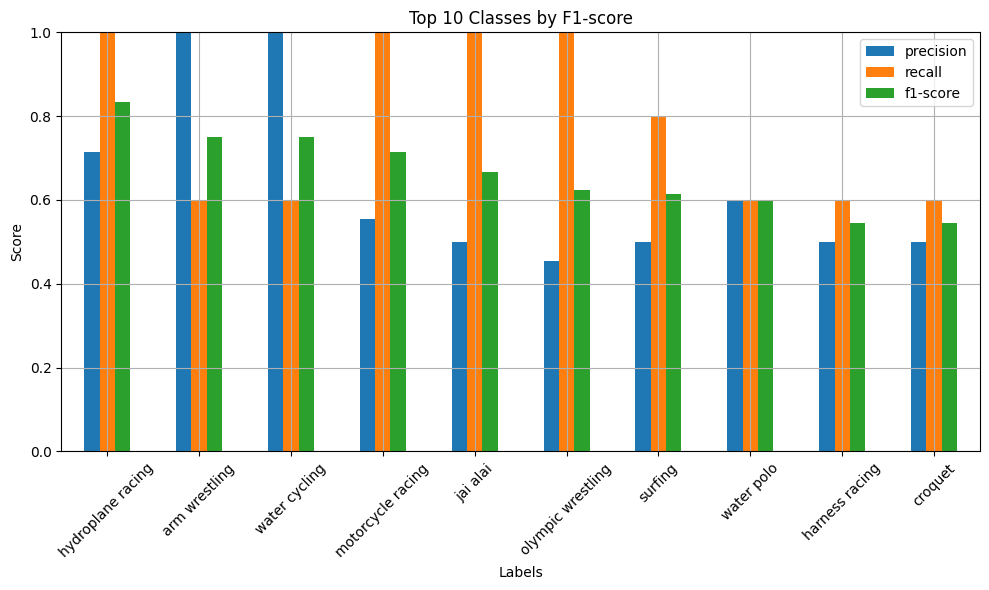

In [ ]:
df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])

# Sort by F1-score and take top 10
top_f1 = df.sort_values(by='f1-score', ascending=False).head(10)
top_f1["labels"] = encoder.inverse_transform(top_f1.index.astype(int))
top_f1.set_index("labels", inplace=True)

# Plot
top_f1[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title("Top 10 Classes by F1-score")
plt.xlabel("Labels")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

## Conclusiones

El nivel de precisión del modelo en general es bajo, con 29.7% y 27.0% de accuracy para el test set y validation set, respectivamente. Por otro lado, el accuracy para el training set es de 96.4%. Por lo tanto, se puede concluir que:

- El modelo es capaz de ajustarse a los datos de entrenamiento con alta precisión
- El modelo tiene un alto overfitting.
- Se aplicaron medidas para controlar el overfitting, como aplicar Dropout y Batch Normalization sin mejoras en los resultados.

Por lo tanto, se estima que es probable que los datos (imagenes) requieran de un preprocesamiento mas complejo antes de realizar el entrenamiento y validación. Se debe incluir en el pipeline procesos como:

- Reducción de ruido
- Eliminación de fondos
- Corrección de contraste y brillo.

Estos procesos estan fuera del alcance de este estudio. Por otro lado, el modelo fue realizado en computadora local y el aumento de la complejidad no es posible con el hardware disponible. Finalmente, el aumento de la complejidad del modelo se espera que no mejore los resultados ya que el modelo se ajusta adecuadamente a los datos de entrenamiento.